# The Brewno Classifier
## Applied Deep Learning Final Project
## Isaac Wainstein, ikw2102

In [1]:
import os, PIL, subprocess, keras, urllib, cv2, scipy.misc, math, re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications import VGG16, VGG19
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile, copytree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### Introduction

This notebook outlines a Deep Learning model that can intake a picture of a dog and tell you whether it is Brewno or not. 

It runs end to end and colab. All images used to train the model are public.

One use of this tool could be a virtual dog tag. You could simply upload pictures of your dog to add them to the system. Then if someone finds your dog they simply can upload a picture and find you. Its like a QR code for your dog! This improves on current dog tags as you can a) add more information such as vet info and multiple phone numbers, b) easily keep the information updated as you change address, and c) attach automatic actions such as send a text with the location.

There are also many just for fun uses cases such as a non-intrusive DNA test. This model would predict breeds of your dog based on features learned from the model. Another idea is you could find other dogs that are your dogs closes twin.

There were many adjustments that were required to get this model to work. Reading through this notebook you will get a sense of some of the challenges of building a new classifier from scratch.

Below is a picture of my dog Brewno. He is a good pup who is always ready to great you with a smile and can even get a beer from the fridge.

#### Import python packages

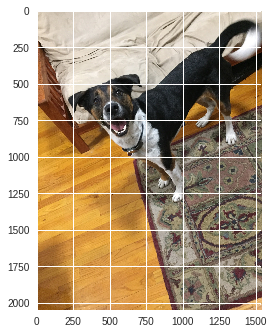

In [2]:
brewno = urllib.urlretrieve ('https://s3.amazonaws.com/isaac-wainstein/brewno/IMG_2219.jpg', 'brewno.jpg')
jpgfile = PIL.Image.open('brewno.jpg')
plt.imshow(jpgfile)
plt.show()

### Load not brewno data

Data from the 'not_brewno' class comes from The Oxford-IIIT Pet Dataset. This dataset includes more than 5,000 pictures of dogs across 25 different breeds. Pictures are taken of dogs from the front and always include a picture of the face. Pictures varying in the pixel dimensions and angle of which it was taken.

http://www.robots.ox.ac.uk/~vgg/data/pets/

In [0]:
# Download dataset
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  20.6M      0  0:00:36  0:00:36 --:--:-- 21.6M


In [0]:
# extract files
!tar xzf images.tar.gz

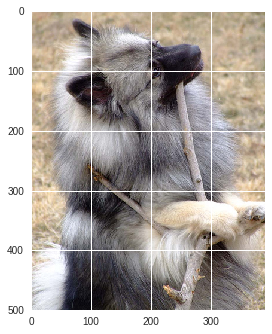

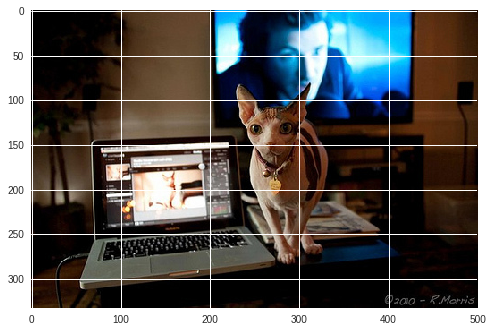

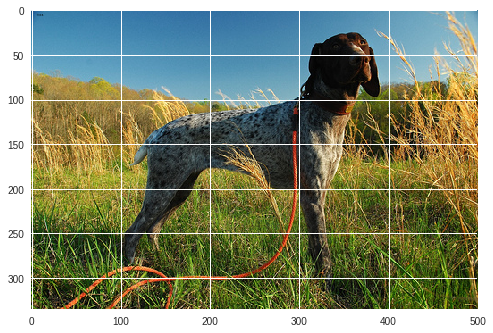

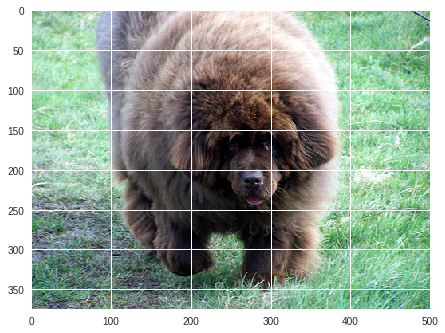

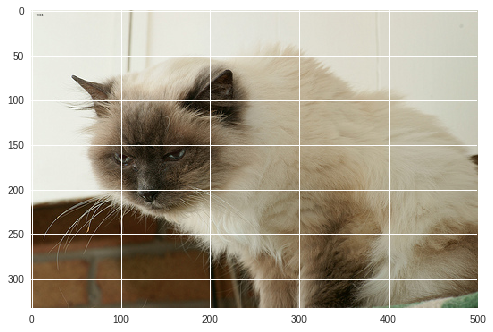

In [0]:
#Present a sample of pictures is provided below.
files = os.listdir('images')[5:10]
for f in files:
  jpgfile = PIL.Image.open('images/' + f)
  plt.imshow(jpgfile)
  plt.show()

### Filter for only dogs

The full dataset inclued cats and dogs. Cats were removed to make it a dog only classifer.

In [0]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  9205k      0  0:00:02  0:00:02 --:--:-- 9205k


In [0]:
!tar xzf annotations.tar.gz

In [0]:
metadata = pd.read_csv('annotations/list.txt', sep=' ', skiprows=6, 
                       names = ['file_name', 'class', 'species', 'breed']) 
metadata.head()

,file_name,class,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [0]:
#remove cats
for file in metadata.file_name[metadata['species'] == 1].values.tolist():
  os.remove('images/' + file + '.jpg')

### Crop top of image

If you look in the top left of the not_brewno images above you will see a logo. Pictures of Brewno do NOT have this logo, and hence the Deep Learning model may simply train to say whether a pictures has a logo or not. This is not robust. Therefore, I cropped all pictures to remove the logo.

In [0]:
files           = os.listdir('images/')
crop_percentage = 0.05
i               = 0
error_count     = 0

for f in files:
  if i%1000 == 0:
    print(i)
  try:
    img  = PIL.Image.open('images/' + f)
    w, h = img.size
    img.crop((0, h * 0.05, w, h)).save('images/' + f)
  except:
    os.remove('images/' + f)
    error_count += 1
    
  i += 1
  
print("Failed to crop {} images.".format(error_count))

0
1000
2000
3000
4000
5000
Failed to crop 9 images.


In [0]:
# Copy images to data folder
copytree('images', 'data/not_brewno/')


### Load brewno data

Next we download pictures of Brewno. The final dataset includes 52 pictures of Brewno that have been taken in various scenarios over the last three years.

In [0]:
os.mkdir('data/brewno')

In [0]:
!curl -O https://s3.amazonaws.com/isaac-wainstein/brewno/brewno_images.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57.5M  100 57.5M    0     0  27.7M      0  0:00:02  0:00:02 --:--:-- 27.7M


In [0]:
!tar xzf brewno_images.tar.gz

In [0]:
files = os.listdir('brewno_images')
for f in files:
  os.rename('brewno_images/' + f, 'data/brewno/' + f)

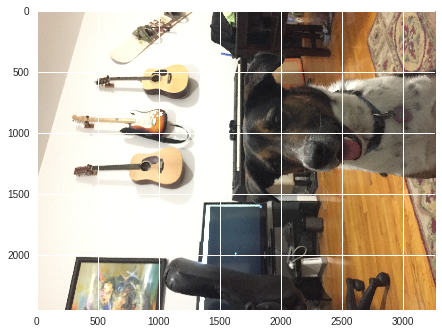

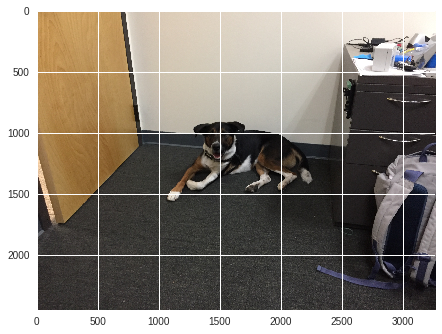

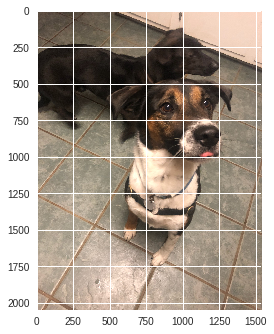

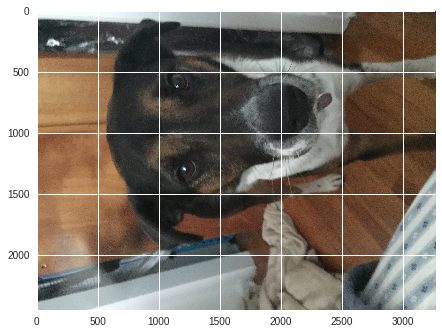

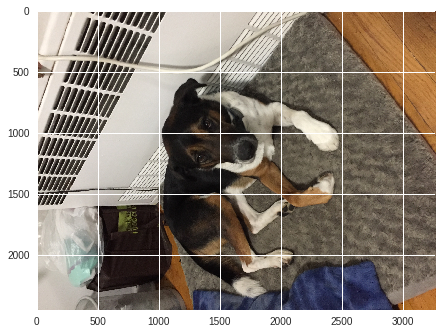

In [0]:
#Present a sample of pictures is provided below.
files = os.listdir('data/brewno')[5:10]
for f in files:
  jpgfile = PIL.Image.open('data/brewno/' + f)
  plt.imshow(jpgfile)
  plt.show()

### Videos were not used

I first started this project by taking videos and converting them into frames. This was an easy way to create thousands of pictures. 

When I did this my model got 99% accuracy. To test the validity of the model I pulled in new pictures of Brewno and not_brewno to test the model and the predictions were not consistent. I tried multiple remedies such as splitting the videos train, test, and validation sets so they were not influencing eachother, but that did not help. Ultimately, I thin there was something about the video quality or resolution that was be trained on. In the end, 52 pictures in different scenarios was better than thousands of image frames form 10 vidoes.

In case it is helpful, example code for converting videos to frames is below.

In [0]:
# # Convert videos to picture frames
# save_rate      = 10 # Save every n frames
# train_test_val = [0, 0, 0, 1, 1, 2] 
# i              = 0
# v              = 0
# videos         = os.listdir('brewno/videos') 

# for video in videos:
#   print(i)
#   # Convert video to numpy arrary X
#   cap         = cv2.VideoCapture('brewno/videos/' + video)
#   frameCount  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#   frameWidth  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#   frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#   X           = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
#   fc          = 0
#   ret         = True

#   while (fc < frameCount  and ret):
#       ret, X[fc] = cap.read()
#       fc += 1


#   # Save numpy array into frame jpegs
#   for frame in np.arange(0, frameCount, save_rate):
#     scipy.misc.imsave('data/brewno_' + str(i) + '.jpg', X[frame])

#     i += 1

#   v += 1

# print('Loaded {} pics'.format(i))

### Load pretrained model

Since I only had 50 images it was important that i included the per-trained model *imagenet*. Including this allows me to use features and shapes learned from many other images, before I added any pictures of Brewno or not_brewno.

In [0]:
# Load VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

58900480/58889256 [==============================] - 4s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool

### Extract features

Next I extracted features from the images. Feature extraction consists of using the representations learned by a previous network to extract features from new samples. 

In [0]:
datagen    = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count, batch_size=batch_size):
    features  = np.zeros(shape=(sample_count, 4, 4, 512))
    labels    = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [0]:
# Get file count
file_count = sum([len(os.listdir('data/' + folder)) for folder in os.listdir('data')])
file_count = int(math.floor(file_count / (batch_size + 0.0)) * batch_size)

In [0]:
#Extract features
features, labels = extract_features('data', file_count)
features         = np.reshape(features, (file_count, 4 * 4 * 512))
labels           = np.array(labels).astype('int')

Found 5064 images belonging to 2 classes.


In [0]:
features.shape

(5060, 8192)

### Split into train, test, and validatio sets

In [0]:
X, X_test, y, y_test = train_test_split(features, labels, test_size=0.25, stratify=labels, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=3)


### Balance data by duplicate Brewno images

Imbalanced data was one of the hardest challenges I faced with this classier. To start I had ~50 pictures of Brewno and ~5,000 pictures of not_brewno. The first model simply guessed not_brewno every time, which led to 99% accuracy.

Next I tried doing 50 of each class, which was good at classifying pictures of Brewno, but not of not_brewno. Hence there were a lot of false negatives. This is because the model may have been trained on a only a couple breeds (only 50 images), and then tested on a breed it had never seen before. I tried increasing the number of not_brewno images, yet every time I did it would tend lead to the model guessing not_brewno almost all the time.

I also tried an ensemble model. To do this i created 100 models with 50 pictures in each class and averaged the predictions. I also took the highest confident predictions. This resulted in some improvement, yet the model was only around 85% accurate. I wanted better.

The final working solution was to create duplicate copies of the Brewno till both classes had 5,000 images. This strategy worked for predictions of brewno and not_brewno images.

Note it is critical to do this duplication step after you split the data into test, train, and validation. otherwise you may leak the same images into multiple sets (i.e test on the same picture it was trained on.)

Future work would include data augmentation, altering the images color and orientation, to create a larger dataset.


In [0]:
# not_brewno_count = len(os.listdir('data/not_brewno'))
# brewno_count     = len(os.listdir('data/brewno')
def duplicate(X, y):
  not_brewno_count = sum(y == 1)
  brewno_count     = sum(y == 0)
  
  ratio = int((not_brewno_count / brewno_count) / 1.25)
  
  for i in range(ratio):
    if i == 0:
      y_dup = np.append(y, y[y == 0])
      X_dup = np.append(X, X[y == 0], axis = 0)
    else:
      y_dup = np.append(y_dup, y[y == 0])
      X_dup = np.append(X_dup, X[y == 0], axis = 0)
    
  return X_dup, y_dup


In [0]:
X_train, y_train = duplicate(X_train, y_train)
X_val, y_val     = duplicate(X_val, y_val)
X_test, y_test   = duplicate(X_test, y_test)

### Define model

The model includes two dense layers on top of imagenet.

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-7),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=20,
                    validation_data=(X_val, y_val))



Train on 5086 samples, validate on 1689 samples
Epoch 1/20
5086/5086 [==============================] - 3s 562us/step - loss: 0.6989 - acc: 0.5590 - val_loss: 0.6791 - val_acc: 0.5571
Epoch 2/20
5086/5086 [==============================] - 2s 431us/step - loss: 0.6464 - acc: 0.6306 - val_loss: 0.6448 - val_acc: 0.6323
Epoch 3/20
5086/5086 [==============================] - 2s 432us/step - loss: 0.6130 - acc: 0.6785 - val_loss: 0.6181 - val_acc: 0.6880
Epoch 4/20
5086/5086 [==============================] - 2s 432us/step - loss: 0.5765 - acc: 0.7249 - val_loss: 0.5947 - val_acc: 0.7128
Epoch 5/20
5086/5086 [==============================] - 2s 433us/step - loss: 0.5460 - acc: 0.7670 - val_loss: 0.5728 - val_acc: 0.7247
Epoch 6/20
5086/5086 [==============================] - 2s 438us/step - loss: 0.5217 - acc: 0.7965 - val_loss: 0.5529 - val_acc: 0.7365
Epoch 7/20
5086/5086 [==============================] - 2s 434us/step - loss: 0.4977 - acc: 0.8195 - val_loss: 0.5350 - val_acc: 0.7425


### Plot accuracy and loss

We can see from the plots below that the train and validation curves are just starting to flatten out at the end. This means our number of epochs was designed well not to overfit.

We have an accuracy of greater than 99% on the training set.

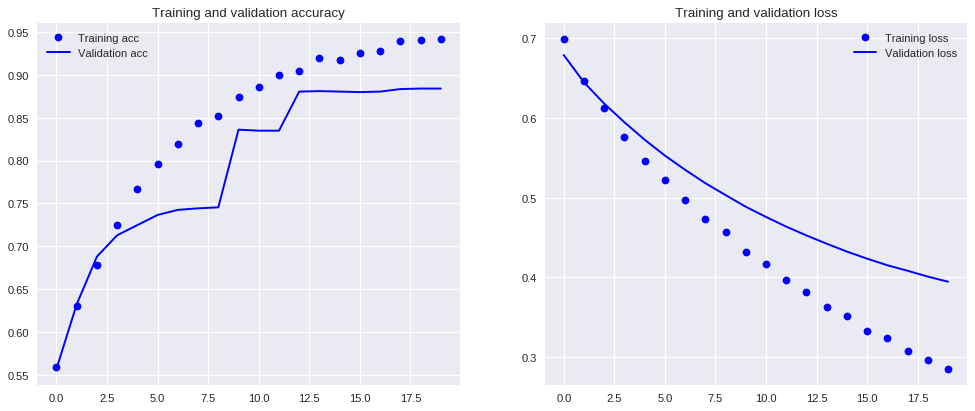

In [0]:

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')


acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()


# Final test set accuracy

We have a final test set accuracy of 94%. This model was tested on completely different set of pictures of Brewno and not_brewno, giving validation to of the robustness of our model. Below is also a confusion matrix, which indicates a couple instances of flase negatives, which are pictures of not_brewno that were predicted to be Brewno. Nonetheless, the amount of errors is quite small.

In [0]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

2253/2253 [==============================] - 0s 100us/step
('Loss: ', 0.3488274905690076)
('Accuracy: ', 0.9356413670925897)


In [0]:
y_pred = model.predict(X_test).reshape((len(y_test)))
print(confusion_matrix(y_test, np.round(y_pred)))

[[ 924   77]
 [  68 1184]]


### Conclusion

A proof of concept has been completed that indicates you can accuratly classify your dog with only ~50 images. 